In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import math
from sklearn import linear_model
from matplotlib import animation
import numpy as np
import cv2

In [2]:
KP = []
with open('Kalibrierung_KerbHal.txt') as f:
	for row in f:
		img, real = row.split(';')
		img = [float(x) for x in img.split(',')]
		real = [float(x) for x in real.split(',')]
		KP += [img, real]

KP = np.array(KP).reshape(-1,2)
# We need to find extrinsic (rotation matrix and translation) and intrinsic (brennweite, pixel size, image center)
#mtx, dist, newcameramtx, roi = getCalibration()


# we define alpha = s_y / s_x; f_x = f/s_x, f_y = f/s_y

#def calibration(imgpoints, realpoints, image):
imgpoints = KP[:,0]
realpoints = KP[:,1]
imgpath = os.path.join(os.getcwd(), '../../Videos/GoPro/GoProFrames/3_image_GP_00306.png')
#'/home/mueller/code/python/Anwendungspraktikum/Videos/GoPro/GoProFrames/3_image_GP_00306.png'
image = plt.imread(imgpath)
R = np.zeros([3,3])
#define central point of goProFrame as imagecenter
o_x, o_y = image.shape[0]/2, image.shape[1]/2
#shift image points to new origin
#imgpoints = np.array(imgpoints) - [o_x, o_y]

In [3]:
KerberHalep = True
if KerberHalep:
    imgpath = os.path.join(os.getcwd(), '../../Videos/GoPro/GoProFrames/3_image_GP_00306.png')
    image = plt.imread(imgpath)
    PathToCaliPoints = '/home/lea/Dokumente/FSU/Anwendungspraktikum/cvtennis/code/Kalibrierung_KerbHal_planar.txt'
else:
    image = cv2.imread('/home/lea/Dokumente/FSU/Anwendungspraktikum/Videos/GoPro/GoProFrames/image_GP_00001.png')
    PathToCaliPoints = '/home/lea/Dokumente/FSU/Anwendungspraktikum/cvtennis/code/Kalibrierung_planar.txt'

In [4]:
def getCalibration(PathToCaliPoints=PathToCaliPoints, image_width=1920, image_height=1080):
    # Using planar calibration (court edges)
    imgpoints = np.array([[]]).reshape(0,2)
    objpoints = np.array([[]]).reshape(0,3)
    with open(PathToCaliPoints) as f:
        for row in f:
            imgp, objp = row.split(';')
            imgp = [float(x.strip('))\n(')) for x in imgp.split(',')] 
            objp = [float(x.strip('))\n(')) for x in objp.split(',')]
            imgpoints = np.append(imgpoints, [imgp], axis=0)
            objpoints = np.append(objpoints, [objp], axis=0)
            print(imgp, objp)
    imgpoints = np.array(imgpoints)
    imgpoints = imgpoints.astype('float32')
    objpoints = np.array(objpoints)
    objpoints = objpoints.astype('float32')

    Parameters = np.zeros(5)
    # Returns camera matrix, distortion coefficients, rotation and translation vector
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([objpoints], [imgpoints], 
                                                       (image_height,image_width), None, distCoeffs=Parameters)

    # Returns the new camera matrix based on the free scaling parameter
    # Alpha set to one to keep all image points, since there can be valuable information in corners
    # Returns new camera matrix and ROI which can be used to crop image
    newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(image_width,image_height),1,(image_width,image_height))

    return mtx, dist, rvecs, tvecs, imgpoints, objpoints, newcameramtx, roi

[1632.0, 828.0] [10.97, 0.0, 0.0]
[535.0, 641.0] [1.37, 5.48, 0.0]
[958.0, 641.0] [5.485, 5.48, 0.0]
[1382.0, 642.0] [9.6, 5.48, 0.0]
[602.0, 487.0] [1.37, 11.88, 0.0]
[959.0, 488.0] [5.486, 11.88, 0.0]
[1317.0, 487.0] [9.6, 11.88, 0.0]
[683.0, 301.0] [1.37, 23.77, 0.0]
[961.0, 302.0] [5.485, 23.77, 0.0]
[1239.0, 302.0] [9.6, 23.77, 0.0]


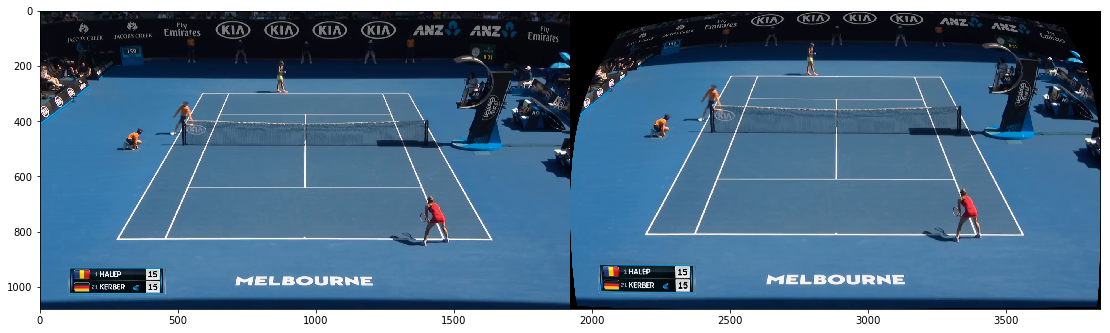

In [5]:
M, D, R, T, imgpoints, objpoints, newM, roi = getCalibration(PathToCaliPoints=PathToCaliPoints, image_width=image.shape[1], image_height=image.shape[0])

# undistort
dst = cv2.undistort(image, M, D, None, newM)

'''# crop the image
x,y,w,h = roi
#dst[y:y+h, x:x+w] = [0,0,0]#dst[y:y+h, x:x+w]
dst[:y, :] = [0,0,0]
dst[:, :x] = [0,0,0]
dst[y+h:, :] = [0,0,0]
dst[:, x+w:] = [0,0,0]'''
images = np.hstack((image, dst))
plt.figure(figsize=(19,8))
plt.imshow(images)
plt.show()

In [6]:
R = cv2.Rodrigues(R[0])[0]
T = T[0].reshape(-1,3)[0]
F = np.zeros((3,4))
F[:,:-1] = np.transpose(R)
F[:,-1] = -np.transpose(R)@T
print(M,'\n \n' ,D, '\n \n',R,'\n \n', T, '\n\n', newM, '\n\n', roi)

[[  3.06829009e+03   0.00000000e+00   1.03076382e+03]
 [  0.00000000e+00   1.84903970e+03   7.95185369e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]] 
 
 [  7.03608304e-01  -1.32710776e+01   2.41858300e-02   1.53166252e-02
   8.44309136e+01] 
 
 [[ 0.99967073 -0.02039793  0.01556773]
 [ 0.00236265 -0.53094778 -0.84740124]
 [ 0.02555088  0.847159   -0.53072477]] 
 
 [ -6.08382279   0.39552413  25.17820774] 

 [[  3.12768384e+03   0.00000000e+00   1.03616835e+03]
 [  0.00000000e+00   2.00234509e+03   7.77793520e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]] 

 (546, 375, 990, 693)


In [7]:
F

array([[  9.99670731e-01,   2.36265218e-03,   2.55508812e-02,
          5.43755970e+00],
       [ -2.03979305e-02,  -5.30947785e-01,   8.47159002e-01,
         -2.12440401e+01],
       [  1.55677258e-02,  -8.47401244e-01,  -5.30724767e-01,
          1.37925773e+01]])

In [8]:
# Check calibration 3D to 2D
for i, val in enumerate(objpoints):
    r = M@(R@val + T)
    print(imgpoints[i], r[0]/r[2], r[1]/r[2])

[ 1632.   828.] 1619.21664907 825.794546324
[ 535.  641.] 534.786056506 639.682785686
[ 958.  641.] 957.805830226 640.828509261
[ 1382.   642.] 1377.86697833 641.966219576
[ 602.  487.] 599.658798878 485.475203244
[ 959.  488.] 957.751523869 486.903947691
[ 1317.   487.] 1313.54941259 488.323536034
[ 683.  301.] 679.002334156 296.869414275
[ 961.  302.] 957.492078338 298.417545806
[ 1239.   302.] 1234.69646462 299.958531999


In [9]:
#[60.0, 899.0] [1.37, 0.0, 0.0]
vti = {'X':0, 'Y':1, 'Z':2}
for i,val in enumerate(imgpoints):
    #S = np.linspace(-10,10,1000)
    #plt.figure(figsize=(10,10))
    #val = [60.0, 899.0]
    #for s in S:
    # cv2.undistort function does something different than expected ?!
    #ip = np.array([[val]], dtype=np.float32)
    #undistp = cv2.undistortPoints(ip, cameraMatrix=M, distCoeffs=D, R=None, P=newM)
    #print(val, undistp)
    #camerapt = np.array(list(undistp[0,0]) + [1])
    #print(camerapt)
    camerapt = np.linalg.inv(M)@np.array([val[0], val[1], 1])
    #print(camerapt)
    X,Y,Z = objpoints[i][0], objpoints[i][1], objpoints[i][2]
    rt = (np.transpose(R)@T)
    a = Z+rt[vti['Z']]
    b = (np.transpose(R)@camerapt)[vti['Z']]
    s = a / b
    r = F@np.append(camerapt*s, 1)
    #r = np.transpose(R)@camerapt*s - np.transpose(R)@np.array(T)
    #plt.plot(s, r[0], 'r.')
    print(val, s, objpoints[i], r)

    #plt.show()

[ 1632.   828.] 25.4141297949 [ 10.97000027   0.           0.        ] [  1.10662770e+01  -5.52801446e-02  -1.11022302e-16]
[ 535.  641.] 29.816751906 [ 1.37        5.48000002  0.        ] [  1.37742721e+00   5.43386741e+00   1.33226763e-15]
[ 958.  641.] 29.9557356535 [ 5.48500013  5.48000002  0.        ] [  5.48689376e+00   5.47398178e+00  -8.88178420e-16]
[ 1382.   642.] 30.0662872784 [ 9.60000038  5.48000002  0.        ] [ 9.64053778  5.47920201  0.        ]
[ 602.  487.] 35.2155892481 [  1.37        11.88000011   0.        ] [  1.40406435  11.80593773   0.        ]
[ 959.  488.] 35.3376669622 [  5.48600006  11.88000011   0.        ] [  5.50036203e+00   1.18264931e+01  -1.77635684e-15]
[ 1317.   487.] 35.5448201959 [  9.60000038  11.88000011   0.        ] [  9.64659513  11.94596697   0.        ]
[ 683.  301.] 45.0726441562 [  1.37        23.77000046   0.        ] [  1.45383659e+00   2.34398614e+01   3.55271368e-15]
[ 961.  302.] 45.2133351776 [  5.48500013  23.77000046   0.        

In [10]:
#[60.0, 899.0] [1.37, 0.0, 0.0]
vti = {'X':0, 'Y':1, 'Z':2}
for i,val in enumerate(imgpoints):

    camerapt = np.linalg.inv(M)@np.array([val[0], val[1], 1])
    #print(camerapt)
    X,Y,Z = objpoints[i][0], objpoints[i][1], objpoints[i][2]+2
    rt = (np.transpose(R)@T)
    a = Z+rt[vti['Z']]
    b = (np.transpose(R)@camerapt)[vti['Z']]
    s = a / b
    r = F@np.append(camerapt*s, 1)
    #r = np.transpose(R)@camerapt*s - np.transpose(R)@np.array(T)
    #plt.plot(s, r[0], 'r.')
    print(val, s, objpoints[i], r)

    #plt.show()

[ 1632.   828.] 21.7289404131 [ 10.97000027   0.           0.        ] [ 10.25008184  -3.12776753   2.        ]
[ 535.  641.] 25.4931579679 [ 1.37        5.48000002  0.        ] [ 1.96616888  1.56542327  2.        ]
[ 958.  641.] 25.6119883034 [ 5.48500013  5.48000002  0.        ] [ 5.47974005  1.59972084  2.        ]
[ 1382.   642.] 25.7065093312 [ 9.60000038  5.48000002  0.        ] [ 9.03108271  1.6041841   2.        ]
[ 602.  487.] 30.1091340353 [  1.37        11.88000011   0.        ] [ 1.98894349  7.01350816  2.        ]
[ 959.  488.] 30.2135098057 [  5.48600006  11.88000011   0.        ] [ 5.49125535  7.03108292  2.        ]
[ 1317.   487.] 30.3906246748 [  9.60000038  11.88000011   0.        ] [ 9.03626171  7.13323238  2.        ]
[ 683.  301.] 38.536861464 [  1.37        23.77000046   0.        ] [  2.03149847  16.96044857   2.        ]
[ 961.  302.] 38.6571515091 [  5.48500013  23.77000046   0.        ] [  5.52226351  16.99715705   2.        ]
[ 1239.   302.] 38.8367229411 [ 

In [11]:
[R, 9]

[array([[ 0.99967073, -0.02039793,  0.01556773],
        [ 0.00236265, -0.53094778, -0.84740124],
        [ 0.02555088,  0.847159  , -0.53072477]]), 9]

In [12]:
objpoint={'X':None, 'Y':None, 'Z':0}
objpoint != None

True

In [13]:
[x for x in objpoint if objpoint[x] != None]

['Z']

In [14]:
import numpy as np

In [51]:
def get_3D_position(imgpoint=[280, 825], objpoint={'X':None, 'Y':None, 'Z':0}, R=R, M=M, T=T, F=F, point=True):
    
    #nones = not all(d.values())
    if objpoint['X'] == None and objpoint['Y'] == None and objpoint['Z'] == None:
        print('Ray will be returned')
    elif len([x for x in objpoint if objpoint[x] != None]) == 1:
        if point:
            print('Return 3D Point for given 3D value')
            key = [x for x in objpoint if objpoint[x] != None][0]
            # Dict for vector position
            vti = {'X':0, 'Y':1, 'Z':2}

            camerapt = np.linalg.inv(M)@np.array([imgpoint[0], imgpoint[1], 1])
            #X,Y,Z = objpoints[i][0], objpoints[i][1], objpoints[i][2]
            rt = (np.transpose(R)@T)
            a = objpoint[key]+rt[vti[key]]
            b = (np.transpose(R)@camerapt)[vti[key]]
            s = a / b
            r = F@np.append(camerapt*s, 1)
            #r = np.transpose(R)@camerapt*s - np.transpose(R)@np.array(T)
            #plt.plot(s, r[0], 'r.')
            return r
            #print(val, s, objpoint, r)
        else:
            print('Return two 3D points which define line in 3D, Z=0 for p1')
            #objpoint={'X':None, 'Y':None, 'Z':0}
            key = [x for x in objpoint if objpoint[x] != None][0]
            # Dict for vector position
            vti = {'X':0, 'Y':1, 'Z':2}
            camerapt = np.linalg.inv(M)@np.array([imgpoint[0], imgpoint[1], 1])
            #X,Y,Z = objpoints[i][0], objpoints[i][1], objpoints[i][2]
            rt = (np.transpose(R)@T)
            a = objpoint[key]+rt[vti[key]]
            b = (np.transpose(R)@camerapt)[vti[key]]
            s = a / b
            r1 = F@np.append(camerapt*s, 1)
            
            s = 20
            r2 = F@np.append(camerapt*s, 1)
            return r1,r2
    else:
        print('Onle one value of 3D Point can be set. Other two values must be None')

In [52]:
get_3D_position(point=True)

Return 3D Point for given 3D value


array([ -7.28316103e-02,  -1.94655695e-02,  -1.05471187e-15])

In [58]:
from sympy import Point, Point3D, Line, Line3D, Plane

def get_trajectory(tr2d):
    start_im = tr2d[0][1:3] 
    end_im = tr2d[-1][1:3]
    start_3D = get_3D_position(imgpoint=start_im, objpoint={'X':None, 'Y':None, 'Z': 1}, point=True)
    end_3D = get_3D_position(imgpoint=end_im, objpoint={'X':None, 'Y':None, 'Z': 0}, point=True)
    print(start_3D, end_3D)
    # Get plane
    X_ws, Y_ws, Z_ws = start_3D[0], start_3D[1], start_3D[2]
    X_we, Y_we, Z_we = end_3D[0], end_3D[1], end_3D[2]
    start = np.array([X_ws, Y_ws, Z_ws])
    ende = np.array([X_we, Y_we, Z_we])
    nv = np.cross((ende-start), [0,1,0])
    plane = Plane(Point3D(X_ws, Y_ws, Z_ws), normal_vector=(nv[0], nv[1], nv[2]))

    # Get point on plane for each point on 2D trajectory
    tr3D = []
    for point in tr2d[1:-1]:
        imgpoint = point[1:3]
        lfa1, lfa2 = np.array(get_3D_position(imgpoint=imgpoint, objpoint={'X':None, 'Y':None, 'Z': 1}, point=False))
        #lfa2 = lfa1
        #np.array(get_3D_position(imgpoint=imgpoint, objpoint={'X':None, 'Y':None, 'Z': 10}))
        print(lfa1, lfa2)
        line = Line3D(Point3D(lfa1[0], lfa1[1], lfa1[2]), Point3D(lfa2[0], lfa2[1], lfa2[2]))

        # Calculate intersect
        res = plane.intersection(line)
        res = [float(x) for x in res[0]]
        tr3D += [res]
        
    return tr3D

In [59]:
trajectory3D = get_trajectory(trajectory)

Return 3D Point for given 3D value
Return 3D Point for given 3D value
[  4.49304609  22.80060846   1.        ] [  7.51051161e+00   6.10163682e+00   4.44089210e-16]
Return two 3D points which define line in 3D, Z=0 for p1
[  4.63988486  22.24784559   1.        ] [ 5.07176706 -1.29980864  7.92623885]
Return two 3D points which define line in 3D, Z=0 for p1
[  4.81197611  21.62835589   1.        ] [ 5.14721914 -1.34646653  7.85539463]
Return two 3D points which define line in 3D, Z=0 for p1
[  4.98617936  20.92335386   1.        ] [ 5.22514688 -1.40069683  7.77258228]
Return two 3D points which define line in 3D, Z=0 for p1
[  5.20142214  20.21922794   1.        ] [ 5.32486985 -1.45688877  7.68768799]
Return two 3D points which define line in 3D, Z=0 for p1
[  5.38733751  19.4215035    1.        ] [ 5.4132026  -1.5217882   7.58834619]
Return two 3D points which define line in 3D, Z=0 for p1
[  5.57807342  18.67546548   1.        ] [ 5.50675937 -1.58463211  7.49253697]
Return two 3D points

# Calculate 3D point from image point and surface

Calculate surface trough start and end point orthogonal to ground 
E = {(x,y,z) | }
Parameterform: (x,y,z) = start + r*(ende-start) + s * (0,1,0)
Normalform: skalarprodukt(kreuzprodukt(ende-start, (0,1,0)),(x,y,z)-start))
[(ende-start) x (0,1,0)] ° [(x,y,z) - start] = 0


# Find court edges (will be done by different script later on)

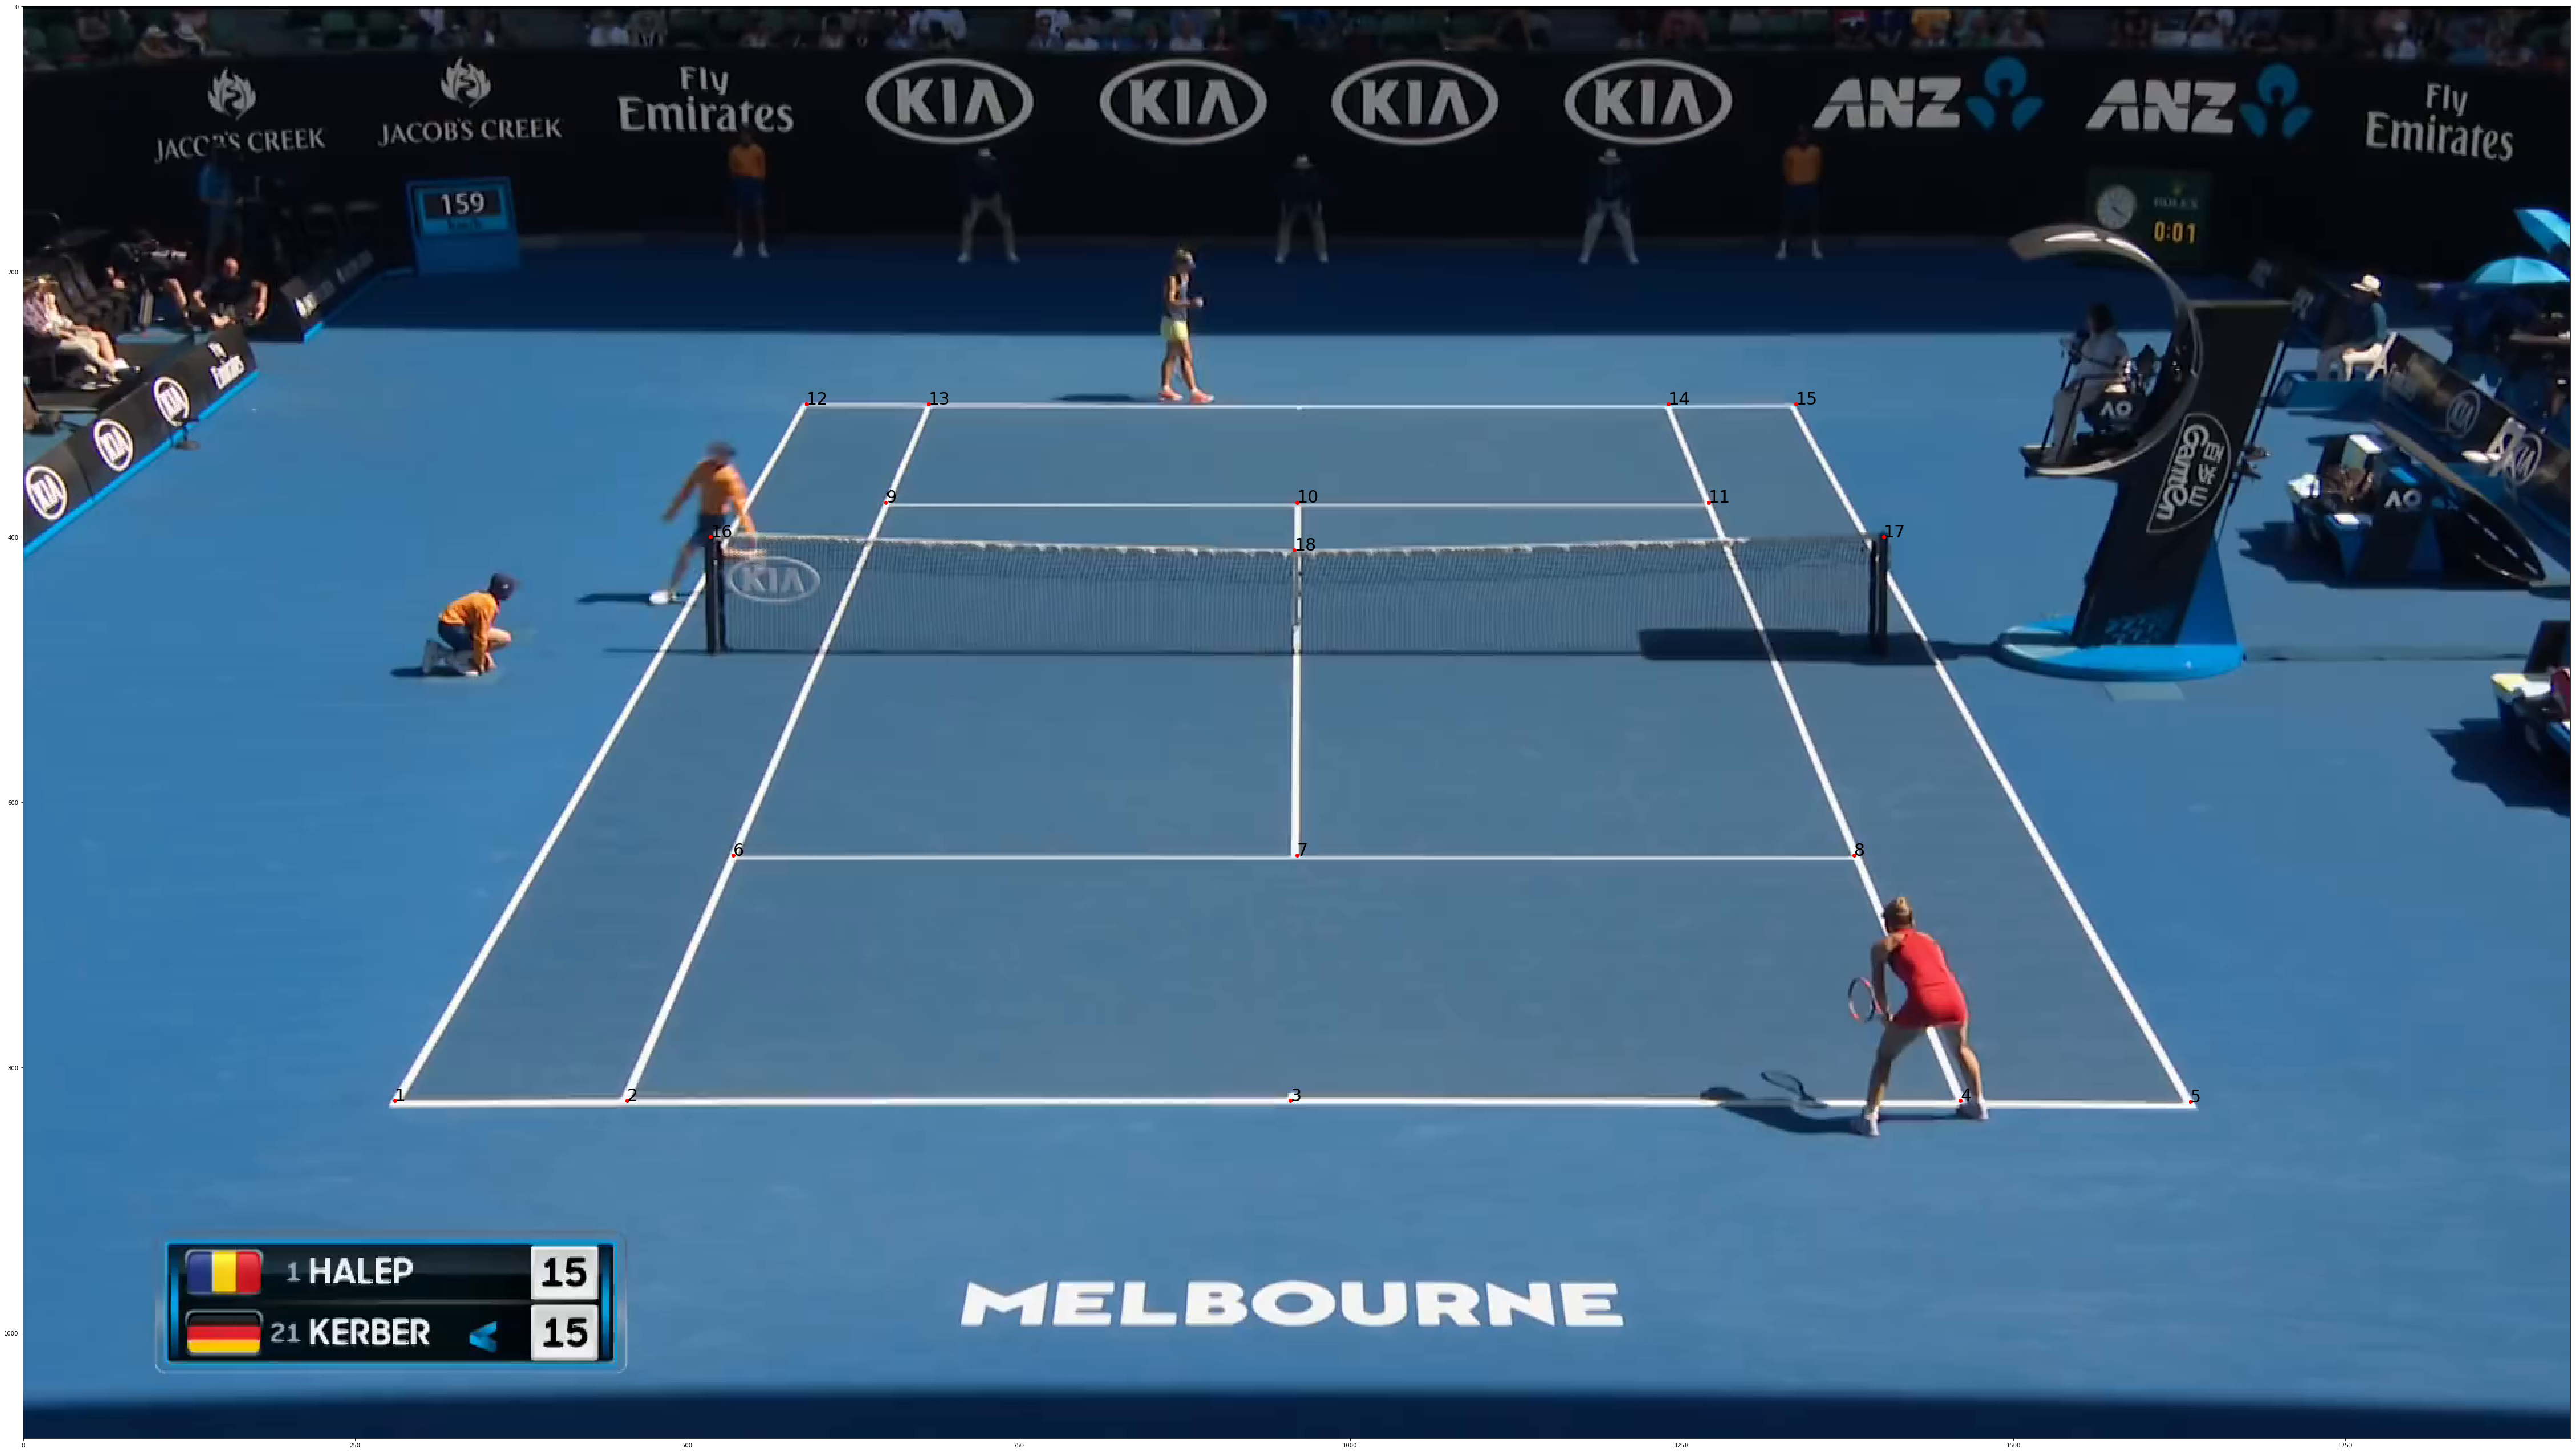

In [20]:
#%matplotlib inline
#[958, 410] [280, 825] [1402, 400]
fig, ax = plt.subplots(figsize=(80,60))
imgpath = os.path.join(os.getcwd(), '../../Videos/GoPro/GoProFrames/3_image_GP_00306.png')
#'/home/mueller/code/python/Anwendungspraktikum/Videos/GoPro/GoProFrames/3_image_GP_00306.png'
img = plt.imread(imgpath)
x = [280, 455,955, 1460, 1633, 535, 960, 1380, 650, 960, 1270, 590, 682, 1240, 1336, 518, 1402, 958]
y = [825, 825, 825, 825, 826,  640, 640, 640,  374, 374, 374,  300, 300, 300,  300,  400, 400, 410]
n = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17, 18]
ax.imshow(img)
ax.scatter(x,y,c='r')
for i, txt in enumerate(n):
    ax.annotate(txt, (x[i],y[i]), size=30)
plt.show()

# Load ball positions detected with Tensorflow Object Detection API

In [21]:
file = os.path.join(os.getcwd(), '../ballpositions.csv')

# Load data into array
print('load into array...')
data = []
with open(file, 'r') as f:
    for i, row in enumerate(f):
        data = data + [row]
        
#/home/lea/Dokumente/FSU/Anwendungspraktikum/cvtennis/code/../../Videos/GoPro/GoProFrames

load into array...


In [22]:
# Keep only Kerber Halep video for further analysis

path = '../../Videos/GoPro/GoProFrames/3_image_GP_00002.png'
image = plt.imread(os.path.join(os.getcwd(), path))

ballpos = np.array([])
for i in range(4756, len(data)):
    row = data[i]
    # Tensorflow output not consistent
    row = row.replace('    ', ' ')
    row = row.replace('   ', ' ')
    row = row.replace('  ', ' ')
    
    # Get path to image, bounding box, accuracy, label and maximum of detected boxes
    path, bb, ac, lb, mx = row.split(';')
    
    # Since only one ball important to us calculate center of bounding box which has highest accuracy
    b1, b2, b3, b4 = [x.strip('[]') for x in bb.split(' ')[0:4]]
    b1, b3 = float(b1) * image.shape[0], float(b3) * image.shape[0]
    b2, b4 = float(b2) * image.shape[1], float(b4) * image.shape[1]
    accuracy = float(ac.split(' ')[0].strip('[]'))
    ballpos = np.append(ballpos, [i-4756, (b2+b4)/2, (b1+b3)/2, accuracy])
    
ballpos = ballpos.reshape(-1,4)
images = ballpos[:,0]

# Smooting of time series with outlier detection

### Outlier detection
Even though we set an accuracy lower bound, there can still be outliier in the ball positions (see above)
Therefore we check if the ballposition is within a reachable distance. Ball speed is set to maximum speed ever reached in tennis (263 km/ h).

In [23]:
framerate = 25
maxspeed_km_h = 160 #(263km/h)
maxspeed_km_sec = maxspeed_km_h / 60 / 60
maxspeed_m_sec = maxspeed_km_sec * 1000
maxdist_m_frame = maxspeed_m_sec / framerate
#Get number of pixels
#Conservative assumption: ball moves orthogonal to optical axis at the opposite court side close to the net
#use outer serve line points as reference distance
x_pxl = [535, 1270]
y_pxl = [640, 374]
dx = x_pxl[1] - x_pxl[0]
dy = y_pxl[0] - y_pxl[1]
physical_dist_m = 2 * np.sqrt(np.sqrt(((9.6-1.37)/2)**2 + ((18.28-5.48) / 2)**2)**2 + 0.914**2)

maxdist_frame_x_pxl = maxdist_m_frame / physical_dist_m * dx
maxdist_frame_y_pxl =  maxdist_m_frame / physical_dist_m * dy
mdist_pxl = int(np.sqrt(maxdist_frame_x_pxl**2 + maxdist_frame_y_pxl**2))
print('Maximum distance of ball within one frame (x, y, both)' , maxdist_frame_x_pxl, maxdist_frame_y_pxl, np.sqrt(maxdist_frame_x_pxl**2 + maxdist_frame_y_pxl**2))

Maximum distance of ball within one frame (x, y, both) 85.2530479918 30.8534840351 90.6643241247


### Smoothing

In [24]:
# Array will contain smoothed ball position
smpos = []


# We set the threshold for accuracy to 0.2, since we can assuma that on almost ever image a ball is visible
# So we rather detect a false positiv than miss an important one while bouncing or hitting
ThesBallDetection = 0.2
for pos in range(1, len(ballpos)-1):
    framecount1 = 1
    framecount2 = 1
    
    # Check detection threshold and if predecessor box (cond2) and successor box (cond3) 
    # or within reachble distance
    cond1 = ballpos[pos, 3] > ThesBallDetection
    cond2 = np.linalg.norm(ballpos[pos, 1:3]-ballpos[pos-1, 1:3]) < mdist_pxl
    cond3 = np.linalg.norm(ballpos[pos+1, 1:3]-ballpos[pos, 1:3]) < mdist_pxl
    if cond1 and (cond2 or cond3):
        j1 = pos-1
        j2 = pos+1
        dist1 = np.linalg.norm(ballpos[pos, 1:3]-ballpos[j1, 1:3])
        dist2 = np.linalg.norm(ballpos[j2, 1:3]-ballpos[pos, 1:3])
        
        # Check if predecessor and successor reach threshold and their distance is within range
        # if not next bounding box in according direction is picked
        while ballpos[j1, 3] < ThesBallDetection or dist1 > framecount1 * mdist_pxl:
            j1 -= 1      
            framecount1 += 1
            if j1 < 0:
                j1 = None
                dist1 = None
                break
            else:
                dist1 = np.linalg.norm(ballpos[pos, 1:3]-ballpos[j1, 1:3])
        
        while ballpos[j2, 3] < ThesBallDetection or dist2 > framecount2 * mdist_pxl:
            j2 += 1
            framecount2 += 1
            if j2 >= len(ballpos):
                j2 = None
                dist2 = None
                break
            else:
                dist2 = np.linalg.norm(ballpos[pos, 1:3]-ballpos[j2, 1:3])
                
        # Calculate mean of three bounding boxes
        if j1 != None and j2 != None and dist1 != None and dist2 != None:
            smpos += [ballpos[pos,0], 
                      np.mean(ballpos[[j1,pos,j2], 1:3], axis=0)[0], 
                      np.mean(ballpos[[j1,pos,j2], 1:3], axis=0)[1], 
                      ballpos[pos,3]]

smpos = np.array(smpos).reshape(-1,4)

### Example smoothed points (red) vs. original points (blue)

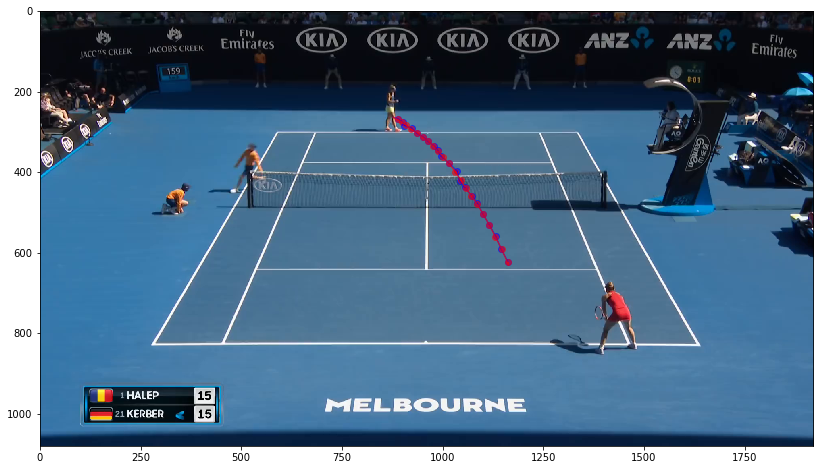

In [25]:
trajectory = []
fig = plt.figure(figsize=(16,8))
plt.imshow(img)
k = 665
oldrow = ballpos[k-1]
oldsmpos = ballpos[k-1]
for i, row in enumerate(ballpos[k:686]): #600-700
    if row[3] >= 0:
        plt.scatter(row[1], row[2], c='b', alpha=.5)
        plt.arrow(oldrow[1], oldrow[2], row[1]-oldrow[1], row[2]-oldrow[2], 
                  width=0.1, head_width=0.5, color='b', alpha=0.5)
        oldrow = row.copy()
        val = np.where(smpos[:, 0] == row[0])
        if len(val[0]) > 0:
            plt.scatter(smpos[int(val[0]), 1], smpos[int(val[0]),2], c='r', alpha=0.5)
            plt.arrow(oldsmpos[1], oldsmpos[2], smpos[int(val[0]),1]-oldsmpos[1], smpos[int(val[0]),2]-oldsmpos[2],
                        width=1, head_width=5, color='r', alpha=0.5)
            oldsmpos = smpos[int(val[0])].copy()
            trajectory += [smpos[int(val[0])]]
#plt.gca().invert_yaxis()
plt.show()

In [65]:
np.around(trajectory3D,2)

array([[  4.64,  22.41,   0.95],
       [  4.81,  21.98,   0.9 ],
       [  4.98,  21.46,   0.84],
       [  5.2 ,  20.98,   0.77],
       [  5.39,  20.36,   0.7 ],
       [  5.58,  19.8 ,   0.64],
       [  5.75,  19.18,   0.58],
       [  5.89,  18.49,   0.54],
       [  6.04,  17.72,   0.49],
       [  6.23,  16.81,   0.42],
       [  6.41,  15.74,   0.36],
       [  6.55,  14.69,   0.32],
       [  6.68,  13.65,   0.28],
       [  6.83,  12.78,   0.23],
       [  6.97,  11.8 ,   0.18],
       [  7.09,  10.78,   0.14],
       [  7.21,   9.63,   0.1 ],
       [  7.32,   8.45,   0.06],
       [  7.43,   7.29,   0.03]])

In [66]:
np.savetxt('../results/trajectory3Dexample.txt', np.around(trajectory3D,2))

# 3D Trajectory

In [26]:
trajectory

[array([  6.65000000e+02,   8.88635085e+02,   2.68840094e+02,
          6.77863000e-01]),
 array([  6.66000000e+02,   8.98241485e+02,   2.75691452e+02,
          7.99379770e-01]),
 array([  6.67000000e+02,   9.09789926e+02,   2.83548452e+02,
          6.38982400e-01]),
 array([  6.68000000e+02,   9.21713158e+02,   2.92715330e+02,
          7.08482100e-01]),
 array([  6.69000000e+02,   9.36980160e+02,   3.02146369e+02,
          5.23847700e-01]),
 array([  6.70000000e+02,   9.50493056e+02,   3.13134221e+02,
          7.26195100e-01]),
 array([  6.71000000e+02,   9.64809133e+02,   3.23745557e+02,
          6.92862030e-01]),
 array([  6.72000000e+02,   9.77119222e+02,   3.34945755e+02,
          5.73399660e-01]),
 array([  6.73000000e+02,   9.87916643e+02,   3.47097191e+02,
          8.18600300e-01]),
 array([  6.74000000e+02,   9.99996250e+02,   3.61089400e+02,
          7.82731060e-01]),
 array([  6.75000000e+02,   1.01605372e+03,   3.78304520e+02,
          7.41615200e-01]),
 array([  

Find 3D Position of starting and end point

In [ ]:
start = trajectory[0][1:3]
end = trajectory[-1][1:3]

# End position on ground, start position in 1m height


# Bounce and hit detection

In [ ]:
backupballpos = ballpos
backupsmpos = smpos

In [ ]:
smpos

In [ ]:
#calculate line through two points
def l(p1,p2):
    return p2-p1

def reg(points):
    reg = linear_model.LinearRegression()
    reg.fit(points[:,0].reshape(-1,1), points[:,1].reshape(-1,1))
    return reg.coef_, reg.intercept_, reg.score(points[:,0].reshape(-1,1), points[:,1].reshape(-1,1))

#calulate angular between two lines
# r1, r2 direction vectors of line
def angular(r1, r2):
    try:
        alphaRad = math.acos(np.dot(r1, r2) / (np.linalg.norm(r1) * np.linalg.norm(r2)))
        alpha = math.degrees(alphaRad)
        return alpha
    #In case lines are (almost) parallel
    except ValueError:
        return 0

In [ ]:
cpreg = np.zeros(len(ballpos))
ang = np.zeros(len(ballpos))

# Number of points used for regression
nump = 5
# Because of smoothing edges disappear. Jump can be used to leave points out
jump = 1

pk = 0

In [ ]:
cpregtest = []
for i in range(jump+nump-1,len(smpos)-nump-jump-1,1):
    
    imgstring = '3_image_GP_'+str(int(smpos[i,0])).zfill(5)+ '.png'
    imgstringrange = ['3_image_GP_'+str(int(smpos[i,0])-1).zfill(5)+ '.png', 
                      '3_image_GP_'+str(int(smpos[i,0])).zfill(5)+ '.png',
                      '3_image_GP_'+str(int(smpos[i,0])+1).zfill(5)+ '.png']
    
    # Calculate regression through nump number of points
    slo1, int1, sc1 = reg(smpos[i-jump-nump+1:i-jump+1, 1:3])
    slo2, int2, sc2 = reg(smpos[i+jump:i+jump+nump, 1:3])
    
    # See one plot
    if i in range(jump+nump-1,jump+nump+3):
        plt.plot(smpos[i-jump-nump+1-pk:i-jump+1, 1], smpos[i-jump-nump+1-pk:i-jump+1, 2], 'bo', alpha=0.5)
        plt.plot(smpos[i+jump:i+jump+nump+pk, 1], smpos[i+jump:i+jump+nump+pk, 2], 'ro', alpha=0.5)
        plt.plot(smpos[i, 1], smpos[i, 2], 'go')
        #print(i, ': ', i-jump-nump+1, i-jump+1, i+jump, i+jump+nump)
        #print(smpos[i-jump-nump+1:i-jump+1, 1:3], smpos[i+jump:i+jump+nump+1, 1:3])
        #print(slo1, int1, sc1)
        a = np.linspace(np.min(smpos[i-jump-nump+1:i-jump+1, 1])-50, np.max(smpos[i-jump-nump+1:i-jump+1, 1])+50, 50)
        b = [val*slo1[0,0]+int1 for val in a]
        plt.plot(a, b, 'b--')
        c = np.linspace(np.min(smpos[i+jump:i+jump+nump, 1])-50, np.max(smpos[i+jump:i+jump+nump, 1])+50, 50)
        d = [val*slo2[0,0]+int2 for val in c]
        plt.plot(c, d, 'r--')
        plt.show()
        
    # Check orientation, since slope must be negativ if x and y < 0
    x1, x2 = 1, 1
    val1 = smpos[i-jump,1:3] - smpos[i-jump-nump+1,1:3]
    if val1[0] < 0 and val1[1] < 0:
        slo1[0, 0] *= -1
        x1 = -1
    if val1[0] < 0 and val1[1] > 0:
        slo1[0, 0] *= -1
        x1= -1
    #print(i, i+jump+nump-1)
    val2 = smpos[i+jump+nump-1,1:3] - smpos[i+jump,1:3]
    if val2[0] < 0 and val2[1] < 0:
        slo2[0, 0] *= -1
        x2 = -1
    if val2[0] < 0 and val2[1] > 0:
        slo2[0, 0] *= -1
        x2 = -1

    #calculate angle if except lines are parallel
    # 2-bounce, 1-hit
    alpha = angular([x1,slo1[0,0]], [x2,slo2[0,0]])
    ang[i] = alpha
    #Distinguish between bounce and hit
    if alpha > 50 and sc1 > 0.6 and sc2 > 0.6:
        r1 = sum(smpos[i-jump-nump+1:i-jump+1, 1:3] - smpos[i+jump, 1:3])
        r2 = sum(smpos[i+jump:i+jump+nump, 1:3] - smpos[i+jump, 1:3])
        # If sign similar hit (1, red), otherwise bounce (2, green)
        if np.sign(r1[0]) != np.sign(r2[0]) and np.sign(r1[1]) != np.sign(r2[1]):
            cpreg[i] = 2
            inrange = [x for x in imgstringrange if x in testdata[:,0]]
            if inrange:
                label = testdata[np.where(testdata[:,0] == inrange)][0,2]
                cpregtest += [imgstring, '2', label]
            else:
                cpregtest += [imgstring, '2', '0']
            
        else:
            cpreg[i] = 1
            inrange = [x for x in imgstringrange if x in testdata[:,0]]
            if inrange:
                label = testdata[np.where(testdata[:,0] == inrange)][0,2]
                cpregtest += [imgstring, '1', label]
            else:
                cpregtest += [imgstring, '1', '0']
        # Add false negativ
    else:
        #print(testdata[np.where(testdata[:,0] == imgstring)])
        if testdata[np.where(testdata[:,0] == imgstring)].size:
            cpregtest += [imgstring, '0', testdata[np.where(testdata[:,0] == imgstring)][0,2]]
        else:
            cpregtest += [imgstring, '0', '0']
    #check if serve
    #cond1 = val1[1] < val2[1]
    #slo2, int2, sc2 = reg(smpos[i+jump:i+jump+nump, 1:3])
    #if cond1 and  abs(slo1) > 8 and abs(slo2) > 8:
    #    cpreg[i] = 3
    #    cpregtest += [imgstring, '3',testdata[np.where(testdata[:,0] == imgstring)][2]]
cpregtestbackup = cpregtest
cpregtest = pd.DataFrame(np.array(cpregtest).reshape(-1,3), columns=['imgname','predicted', 'actual'])
cpregtest = cpregtest.set_index('imgname')
confusion_matrix(cpregtest['actual'][:len(testdata)],cpregtest['predicted'][:len(testdata)])#score = 

### Area prediction

In [ ]:
smpos[1:6,0]

A bounce will keep it's y-direction in the long term, but change it in the short term, it keeps it's x-direction
A bounce has a negativ ydirection (it's falling!) which turns into a positive direction after bounce
A hit can change or keep it's x direction but change it's y direction

In [ ]:
# Given ball positions we try to predict the next one
nump = 15
for i in range(nump,len(smpos),1):
    
    # Calculate regression through nump number of points
    fit = np.polyfit(smpos[i-nump:i,1], smpos[i-nump:i,2], deg=2, full=True)
    p2 = np.poly1d(fit[0])
    
    # Calculate which point is expected next
    # Get average moved distance in x direction from last nump points
    sumdist = 0
    n = 0
    o = 0
    for j in range(len(smpos[i-nump:i])):
        sumdist += abs(smpos[i-nump+j+1, 1] - smpos[i-nump+j,1]) / (smpos[i-nump+j+1, 0] - smpos[i-nump+j,0])
        n += 1
        # Get orientation
        if j == len(smpos[i-nump:i])-1:
            if smpos[i-nump+j+1, 1] > smpos[i-nump+j,1]:
                o += 1
            else:
                o -= 1
    
    
    avgdist = sumdist / n
    # Next expected point
    xexp = smpos[i-1,1] + o * (smpos[i-1,0]-smpos[i-2,0]) * avgdist
    yexp = p2(xexp)
    print('Average distance: ', avgdist, o)
    print('Xexp vs XReal: ', xexp, smpos[i,1])        
    
    # Calculate expectation area
    
    
    
    xp = np.linspace(min(smpos[i-nump:i,1])-20, max(smpos[i-nump:i,1])+20, 10)
    plt.plot(smpos[i-nump:i,1], smpos[i-nump:i,2], '.', 
             xexp, yexp, 'g.',
             smpos[i,1], smpos[i,2], 'r.', 
             xp, p2(xp),'--')
    # plt.axis([600, 1400, 0, 800])
    plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix

In [ ]:
cpregtest = pd.DataFrame(np.array(cpregtest).reshape(-1,3), columns=['imgname','predicted', 'actual'])
cpregtest = cpregtest.set_index('imgname')
confusion_matrix(cpregtest['actual'][:len(testdata)],cpregtest['predicted'][:len(testdata)])

In [ ]:
confusion_matrix(cpregtest['actual'],cpregtest['predicted'])

# Performance measurement

A hit or bounce is detected correctly, if it is within one frames before or after the labeled frame.

In [ ]:
testdata

In [ ]:
cpregtest = np.array(cpregtest).reshape(-1,2)
cpregtest[0:5]

In [ ]:
testdata = []
labels = {'Hit': 1, 'Bounce': 2}
with open('../annotations/BounceHit.txt', 'r') as f:
    for row in f:
        frame, label = row.split(' ')[:-1]
        frame = '3_image_GP_' + frame + '.png'
        labelnum = labels[label]
        testdata += [frame, label, labelnum]
        
testdata = np.array(testdata).reshape(-1,3)

In [ ]:
#testdata[np.where(testdata[:,0] == '3_image_GP_00397.png')]
if not [x for x in ['3_image_GP_00396.png','3_image_GP_00398.png', '3_image_GP_00398.png'] if x in testdata[:,0]]:
    print('yes')

In [ ]:
plt.figure(figsize=(4,4))
plt.xlim(-1, 1)
plt.ylim(-1, 1)

a = [1, 2.46633910058] 
b = [1, -0.546371568515]
e = np.linspace(-1,1, 50)
f = [val*a[1] for val in e]
plt.plot(e, f, 'b--')

g = np.linspace(-1,1, 50)
h = [val*b[1] for val in g]
plt.plot(g, h, 'r--')
plt.show()
angular(a,b)

In [ ]:
a = [1,5]
b = [3,7]
angular(a,b)

for i in range(0,len(smpos-nump)-nump,1):
    #plt.plot(ballpos[i:i+nump, 1], ballpos[i:i+nump, 2], 'bo', alpha=0.5)
    #plt.plot(ballpos[i+1:i+nump+1, 1], ballpos[i+1:i+nump+1, 2], 'ro', alpha=0.5)
    slo1, int1 = reg(smpos[i:i+nump, 1:3])
    slo2, int2 = reg(smpos[i+1:i+nump+1, 1:3])
    x1, x2 = 1, 1
    #Check orientation, since slope must be negativ if x and y < 0
    val1 = smpos[i+nump-1,1:3] - smpos[i,1:3]
    if val1[0] < 0 and val1[1] < 0:
        slo1[0, 0] *= -1
        x1 = -1
    if val1[0] > 0 and val1[1] < 0:
        slo1[0, 0] *= -1
        x1= -1

    val2 = smpos[i+nump,1:3] - smpos[i+1,1:3]
    if val2[0] < 0 and val2[1] < 0:
        slo2[0, 0] *= -1
        x2 = -1
    if val2[0] > 0 and val2[1] < 0:
        slo2[0, 0] *= -1
        x2 = -1

    #calculate angle if except lines are parallel
    # 2-bounce, 1-hit
    alpha = angular([x1,slo1[0,0]], [x2,slo2[0,0]])
    ang[i+1] = alpha
    #Distinguish between bounce and hit
    if alpha > 50:
        r1 = sum(smpos[i+1-3:i+1, 2] - smpos[i+1, 2])
        r2 = sum(smpos[i+1:i+1+3, 2] - smpos[i+1, 2])
        if np.sign(r1) != np.sign(r2):
            cpreg[i+1] = 2
        else:
            cpreg[i+1] = 1


for i in range(0,len(ballpos-nump)-nump,1):
    #plt.plot(ballpos[i:i+nump, 1], ballpos[i:i+nump, 2], 'bo', alpha=0.5)
    #plt.plot(ballpos[i+1:i+nump+1, 1], ballpos[i+1:i+nump+1, 2], 'ro', alpha=0.5)
    slo1, int1 = reg(ballpos[i:i+nump, 1:3])
    slo2, int2 = reg(ballpos[i+1:i+nump+1, 1:3])
    x1, x2 = 1, 1
    #Check orientation, since slope must be negativ if x and y < 0
    val1 = ballpos[i+nump-1,1:3] - ballpos[i,1:3]
    if val1[0] > 0 and val1[1] > 0:
        slo1[0, 0] *= -1
        x1 = -1
    if val1[0] < 0 and val1[1] > 0:
        slo1[0, 0] *= -1
        x1= -1

    val2 = ballpos[i+nump,1:3] - ballpos[i+1,1:3]
    if val2[0] < 0 and val2[1] < 0:
        slo2[0, 0] *= -1
        x2 = -1
    if val2[0] < 0 and val2[1] > 0:
        slo2[0, 0] *= -1
        x2 = -1

    '''
    x1 = np.linspace(np.min(ballpos[i:i+nump, 1]), np.max(ballpos[i:i+nump, 1]), 500)
    y1 = [val*slo1[0,0]+int1 for val in x1]
    plt.plot(x1, y1, 'b--')

    x = np.linspace(np.min(ballpos[i+1:i+nump+1, 1]), np.max(ballpos[i+1:i+nump+1, 1]), 500)
    y = [val*slo2[0,0]+int2 for val in x]
    plt.plot(x, y, 'r--')

    plt.show()
    '''
    #calculate angle if except lines are parallel
    # 2-bounce, 1-hit
    alpha = angular([x1,slo1[0,0]], [x2,slo2[0,0]])
    ang[i+1] = alpha
    #Distinguish between bounce and hit
    if alpha > 50:
        r1 = sum(ballpos[i+1-3:i+1, 2] - ballpos[i+1, 2])
        r2 = sum(ballpos[i+1:i+1+3, 2] - ballpos[i+1, 2])
        if np.sign(r1) != np.sign(r2):
            cpreg[i+1] = 2
        else:
            cpreg[i+1] = 1


In [ ]:
%matplotlib notebook

fig = plt.figure()
imgpath = os.path.join(os.getcwd(), '../../Videos/GoPro/GoProFrames/3_image_GP_00306.png')
#'/home/mueller/code/python/Anwendungspraktikum/Videos/GoPro/GoProFrames/3_image_GP_00306.png'
img = plt.imread(imgpath)
plt.imshow(img)
plt.show()

In [ ]:
%matplotlib notebook

imgpath = os.path.join(os.getcwd(), '../../Videos/GoPro/GoProFrames/3_image_GP_' + str(int(ballpos[1,0])).zfill(5) +'.png')
img = plt.imread(imgpath)

fig,ax = plt.subplots(1,1)
plt.imshow(img)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(0,1920)
ax.set_ylim(0,1080)
scatter, = ax.plot([], [], 'b.')
cmap = ['b', 'r', 'g', 'y']
#scatter = []
scatter = [ax.imshow(img)]
for c in cmap:
    scatter.append(ax.plot([], [], '.', color=c))

#scatter.append(ax.text([],[],[]))
#for scat in scatter[1:]:
#    print(scat[0])
#    scat[0].set_data([],[])
#scatter[0].set_data(img)
#print(scatter[0])

def init():
    for scat in scatter[1:]:
        print(scat[0])
        scat[0].set_data([],[])
    scatter[0].set_data(img)
    return scatter

def pltpos(i):
    i += 310
    npoi = 20
    imgpath = os.path.join(os.getcwd(), '../../Videos/GoPro/GoProFrames/3_image_GP_' + str(int(ballpos[i,0])).zfill(5) +'.png')
    #'/home/mueller/code/python/Anwendungspraktikum/Videos/GoPro/GoProFrames/3_image_GP_00306.png'
    img = plt.imread(imgpath)
    j = np.where(smpos[:,0] == int(ballpos[i,0]))
    if len(j[0]) > 0:
        vals = [k+int(j[0]) for k,x in enumerate(smpos[int(j[0]):int(j[0])+npoi, 3]) if x > 0.03]
        blue = [k for k in vals if cpreg[k] == 0]
        red = [k for k in vals if cpreg[k] == 1]
        green = [k for k in vals if cpreg[k] == 2]
        pink = [k for k in vals if cpreg[k] == 3]
        x = smpos[blue,1]
        y = smpos[blue,2]
        x1 = smpos[red, 1]
        y1 = smpos[red, 2]
        x2 = smpos[green, 1]
        y2 = smpos[green, 2]
        x3 = smpos[pink, 1]
        y3 = smpos[pink, 2]
        xlist = [x, x1, x2, x3]
        ylist = [y, y1, y2, y3]
        for lnum, scat in enumerate(scatter[1:]):
            scat[0].set_data(xlist[lnum], ylist[lnum])
    else:
        for lnum, scat in enumerate(scatter[1:]):
            scat[0].set_data([0],[0])
    scatter[0].set_data(img)
    print(i, imgpath, j[0])
    return scatter

#for i in range(100,200):
#    pltpos(i)

ani = animation.FuncAnimation(fig, pltpos, init_func=init, frames=20000, interval=200, blit=True)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
%matplotlib notebook

fig,ax = plt.subplots(1,1)
#plt.imshow(img)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(0,1920)
ax.set_ylim(0,1080)
scatter, = ax.plot([], [], 'b.')
cmap = ['b', 'r', 'g', 'y']
#scatter = []
scatter = [ax.imshow(img)]
for c in cmap:
    scatter.append(ax.plot([], [], '.', color=c))

#scatter.append(ax.text([],[],[]))
#for scat in scatter[1:]:
#    print(scat[0])
#    scat[0].set_data([],[])
#scatter[0].set_data(img)
#print(scatter[0])

def init():
    for scat in scatter[1:]:
        print(scat[0])
        scat[0].set_data([],[])
    scatter[0].set_data(img)
    return scatter

def pltpos(i):
    i += 0
    np = 20
    imgpath = os.path.join(os.getcwd(), '../../Videos/GoPro/GoProFrames/3_image_GP_' + str(int(smpos[i,0])).zfill(5) +'.png')
    #'/home/mueller/code/python/Anwendungspraktikum/Videos/GoPro/GoProFrames/3_image_GP_00306.png'
    img = plt.imread(imgpath)
    vals = [k+i for k,x in enumerate(smpos[i:i+np, 3]) if x > 0.03]
    blue = [k for k in vals if cpreg[k] == 0]
    red = [k for k in vals if cpreg[k] == 1]
    green = [k for k in vals if cpreg[k] == 2]
    pink = [k for k in vals if cpreg[k] == 3]
    x = smpos[blue,1]
    y = smpos[blue,2]
    x1 = smpos[red, 1]
    y1 = smpos[red, 2]
    x2 = smpos[green, 1]
    y2 = smpos[green, 2]
    x3 = smpos[pink, 1]
    y3 = smpos[pink, 2]
    xlist = [x, x1, x2, x3]
    ylist = [y, y1, y2, y3]
    for lnum, scat in enumerate(scatter[1:]):
        scat[0].set_data(xlist[lnum], ylist[lnum])
    scatter[0].set_data(img)
    return scatter

ani = animation.FuncAnimation(fig, pltpos, init_func=init, frames=20000, interval=200, blit=True)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
i = 500
r1 = sum(ballpos[i+1-3:i+1, 2] - ballpos[i+1, 2])
r2 = sum(ballpos[i+1:i+1+3, 2] - ballpos[i+1, 2])
print(ballpos[i+1-3:i+1, 2], ballpos[i+1, 2], r1)
print(ballpos[i+1:i+1+3, 2], ballpos[i+1, 2], r2)
np.sign(r2)
if np.sign(r1) != np.sign(r2):
    print('YAY')

In [ ]:
i=418
for k in range(3):
    i += k
    if ballpos[i,3] > 0.08:
        print(i, ballpos[i,1:3], ballpos[i+1,1:3], ballpos[i+2,1:3])
        print(l(ballpos[i,1:3], ballpos[i+1,1:3]), l(ballpos[i+1,1:3], ballpos[i+2,1:3]))
        print(angular(l(ballpos[i,1:3], ballpos[i+1,1:3]), l(ballpos[i+1,1:3], ballpos[i+2,1:3])))

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(coords[:,0], coords[:,1],'.')
for i in range(len(cp)):
    if cp[int(i)] == 1:
        plt.scatter(coords[int(i),0], coords[int(i),1], c='r')
plt.gca().invert_yaxis()
#plt.scatter(coords[:,0], cp)
plt.show()

In [ ]:
i=600
val = [k+i for k,x in enumerate(ballpos[i:i+15, 3]) if x > 0.05]
print(val, cpreg[600:615])

In [ ]:
%matplotlib notebook

fig,ax = plt.subplots(1,1)
plt.imshow(img)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(0,1920)
ax.set_ylim(0,1080)
scatter, = ax.plot([], [], 'bo')
cmap = ['b', 'r', 'g']
scatter = []
for c in cmap:
    scatter.append(ax.plot([], [], 'o', color=c))

def init():
    for scat in scatter:
        scat[0].set_data([],[])
    return scatter

def pltpos(i):
    i += 306
    np = 20
    vals = [k+i for k,x in enumerate(ballpos[i:i+np, 3]) if x > 0.03]
    blue = [k for k in vals if cpreg[k] == 0]
    red = [k for k in vals if cpreg[k] == 1]
    green = [k for k in vals if cpreg[k] == 2]
    x = ballpos[blue,1]
    y = ballpos[blue,2]
    x1 = ballpos[red, 1]
    y1 = ballpos[red, 2]
    x2 = ballpos[green, 1]
    y2 = ballpos[green, 2]
    xlist = [x, x1, x2]
    ylist = [y, y1, y2]
    for lnum, scat in enumerate(scatter):
        scat[0].set_data(xlist[lnum], ylist[lnum])
    return scatter

ani = animation.FuncAnimation(fig, pltpos, init_func=init, frames=20000, interval=200, blit=True)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation 

fig,ax = plt.subplots(1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(400,1800)
ax.set_ylim(200,800)
#scatter, = ax.plot([], [], 'bo')
cmap = ['b', 'r']:
scatter = []
for c in cmap:
    scatter.append(ax.plot([], [], 'b', color=c)

def init():
    scatter.set_data([],[])
    return scatter,

def pltpos(i):
    i += 600
    nump = 15
    val = [k+i for k,x in enumerate(ballpos[i:i+nump, 3]) if x > 0.05]
    x = ballpos[val,1]
    y = ballpos[val,2]
    if cp[i] == 1:
        scatter.set_data(ballpos[i,1], ballpos[i,2])
    #    plt.scatter(row[1], row[2], c='r')
    scatter.set_data(x, y)
    time.sleep(0.5)
    return scatter, 

ani = matplotlib.animation.FuncAnimation(fig, pltpos, init_func=init, 
                                         frames=200, interval=200, blit=True)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
%matplotlib notebook

def pltpos(ax, i, colors=['b']):
    ax.plot(ballpos[i,1], ballpos[i,2], c='b')
    fig.canvas.draw()

fig,ax = plt.subplots(1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(600,900)
ax.set_ylim(200,800)
for i in range(600,605):
    pltpos(ax, i, ['b', 'r'])
    time.sleep(10)

In [ ]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from IPython import display
#%matplotlib inline

fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.xlim=(500,1000)
plt.ylim(200,800)
#ax1 = fig.add_subplot(1,1,1)
fig.show()

for i, row in enumerate(ballpos[600:650]):
    try:
        if row[3] > 0.05:
            plt.scatter(row[1], row[2], c='b')
            if cp[int(i+u)] == 1:
                plt.scatter(row[1], row[2], c='r')
            #display.clear_output(wait=True)
            #display.display(plt.gcf())
            fig.canvas.draw()
            time.sleep(1)
    except KeyboardInterrupt:
        break      

In [ ]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(1,1,1)
u, o = 600, 700
for i, row in enumerate(ballpos[u:o]):
    if row[3] > 0.05:
        plt.scatter(row[1], row[2], c='b')
        if cp[int(i+u)] == 1:
            plt.scatter(row[1], row[2], c='r')
plt.gca().invert_yaxis()
plt.show()